# MCSim_Test.jpynb
## Class MCVar
## Class MCVector
## Class MCSimulation
## Calculation with base function method according to <a href="https://doi.org/10.1088/1681-7575/aa7b39">Fourier</a> and <a href=" https://doi.org/10.5194/amt-11-3595-2018">Chebyshev</a>


In [1]:
from empir19nrm02.tools.help import strd, label_font_size, save_fig

import luxpy as lx
import numpy as np
from matplotlib import pyplot
%matplotlib inline

from empir19nrm02.tools import  plot_2D, plotCorrMatrixSmall
from empir19nrm02.tools.help import plotCorrelation
from empir19nrm02.MC import MCVar, DistributionParam, NameUnit, MCVectorVar, py_getBaseFunctions, generate_base_functions, noise_list_default
from empir19nrm02.MC import load_from_excel, save_to_excel, save_to_csv
from empir19nrm02.spectral.spectral_data import _CORR_PATH

print('Version of luxpy:', lx.__version__)
out_dir = 'MCSim_Test'

import os
print( 'CWD:', os.getcwd())

Version of luxpy: v1.10.0
CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


In [2]:
def plotMCResult( wl, mcVarData, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g-'
    else:
        if diagnumber == 1:
            color1 = 'r--'
            color2 = 'g--'
        else:
            color1 = 'r-.'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVarData.v_mean / np.max(mcVarData.v_mean), color1, label= title + ' $s_{\mathrm{rel}}(\lambda)$')
    ax2.plot(wl, mcVarData.v_std / mcVarData.v_mean, color2, label= title + ' $u_{\mathrm{rel}}(s_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(strd['xlambda'])
    ax1.set_ylabel('Signal / A.U', color = 'red')
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green')
    if title:
        ax1.set_title(title)
    fig.legend(bbox_to_anchor=(1,1), loc="upper left")
    return fig, ax1, ax2

In [3]:
## Read some detector data from an xls file

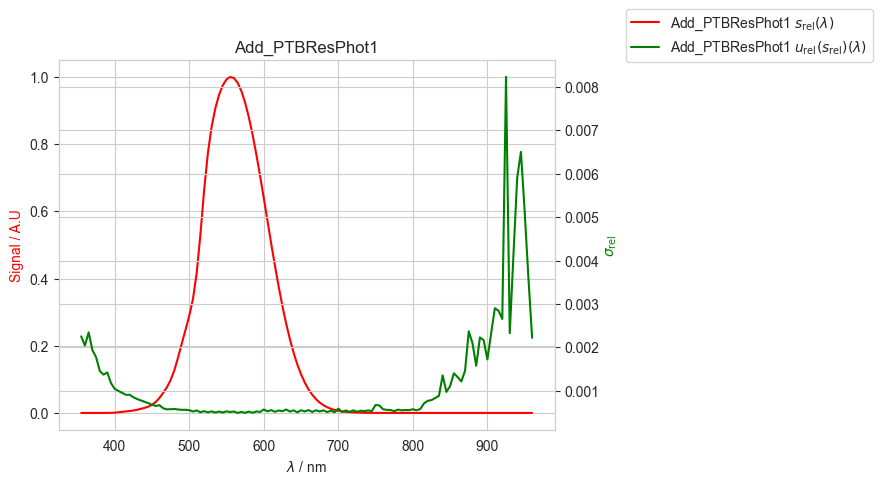

In [4]:
filenameTest = 'Add_PTBResPhot1'
wl, mcVar = load_from_excel(filename = _CORR_PATH + '/' + filenameTest, wlColumn = 1, valColumn=2, stdColumn = 3, covColumn=None, corrColumn = 4, startRow=2)

plotMCResult(wl, mcVar.setData, title=filenameTest)
save_to_excel(wl, mcVar, filename = out_dir + '/' + filenameTest, use_runData=False)
save_to_csv(wl, mcVar, filename = out_dir + '/' + filenameTest, use_runData=False)
save_fig(out_dir, filenameTest)


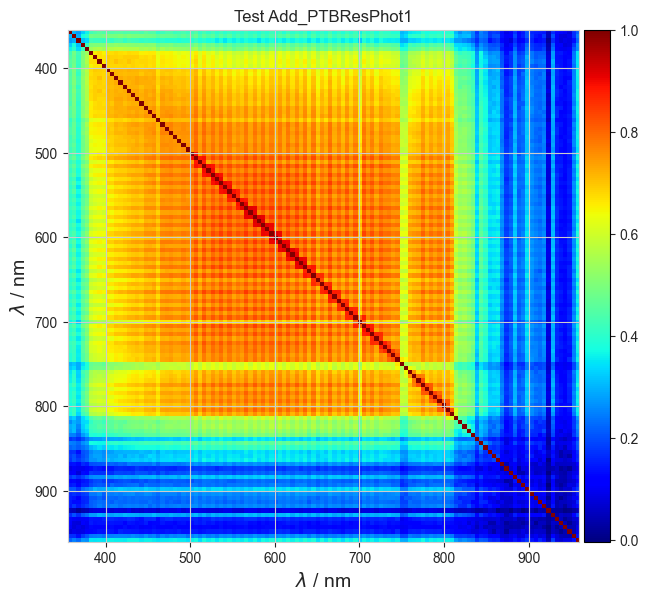

In [5]:
plotCorrelation(mcVar.setData.corr_matrix, wl, 'Test ' + filenameTest)
save_fig(out_dir, 'Corr_' + filenameTest)


# Test Class MCVar

In [6]:
from empir19nrm02.MC import MCVar, DistributionParam, NameUnit

var1 = MCVar(name=NameUnit('var1', 'Unit_var1'), distribution=DistributionParam())
var1.generate_numbers()
var1.print_stat()
var1.pickle()

var = MCVar(name=NameUnit('var1Load', 'Unit_var1Load'))
var1Load = var
var1Load.unpickle('var1')
var1Load.print_stat(out_all=True)

var2 = MCVar(name=NameUnit('var2', 'Unit_var2'),
             distribution=DistributionParam(mean=1, stddev=2, distribution='triangle', add_params=4))
var2.generate_numbers()
var2.print_stat(out_all=True)
var2.pickle()

var2Load = MCVar()
var2Load.unpickle('var2')
var2Load.print_stat(out_all=True)

var2Load.generate_numbers(file='var1.pkl')
var2Load.print_stat(out_all=True)

Name: var1 NameUnit(name='var1', unit='Unit_var1') Values: [0.004161560507506146, 1.0042652844509103] 241.3193999317159 Interval: [-1.9591711070097606, 1.9691554455472575]
Name: var1Load NameUnit(name='var1', unit='Unit_var1') Values: [0.004161560507506146, 1.0042652844509103] 241.3193999317159 Interval: [-1.9591711070097606, 1.9691554455472575]
    trials: 10000 step: 0 Distribution: Distribution: Mean:0.0000, StdDev: 1.0000, Dist: normal, Add_Param: None
Name: var2 NameUnit(name='var2', unit='Unit_var2') Values: [0.9906722906051687, 2.0296889997348173] 2.048799607077884 Interval: [-2.7671398209736044, 4.865755447392226]
    trials: 10000 step: 0 Distribution: Distribution: Mean:1.0000, StdDev: 2.0000, Dist: triangle, Add_Param: 4
Name: var2Load NameUnit(name='var2', unit='Unit_var2') Values: [0.9906722906051687, 2.0296889997348173] 2.048799607077884 Interval: [-2.7671398209736044, 4.865755447392226]
    trials: 10000 step: 0 Distribution: Distribution: Mean:1.0000, StdDev: 2.0000, Di

# Test Class MCVectorVar

Name: var1V NameUnit(name='var1', unit='Unit_var1') Values: [array([-6.7129e-03, -8.6099e-03]), array([1.5020e+00, 1.9862e+00])] [-2.2375e+02 -2.3069e+02] Interval: [array([-2.8820e+00, -3.8537e+00]), array([2.9132e+00, 3.9470e+00])]
Set: Corr: [[1.0000e+00 0.0000e+00]
 [0.0000e+00 1.0000e+00]] Cov: [[2.2500e+00 0.0000e+00]
 [0.0000e+00 4.0000e+00]]
Data: Corr: [[1.0000e+00 -9.1581e-04]
 [-9.1581e-04 1.0000e+00]] Cov: [[2.2562e+00 -2.7324e-03]
 [-2.7324e-03 3.9453e+00]]
Name: var2V NameUnit(name='var2', unit='Unit_var2') Values: [array([-6.7129e-03, -8.6099e-03]), array([1.5020e+00, 1.9862e+00])] [-2.2375e+02 -2.3069e+02] Interval: [array([-2.8820e+00, -3.8537e+00]), array([2.9132e+00, 3.9470e+00])]
Set: Corr: [[1.0000e+00 0.0000e+00]
 [0.0000e+00 1.0000e+00]] Cov: [[2.2500e+00 0.0000e+00]
 [0.0000e+00 4.0000e+00]]
Data: Corr: [[1.0000e+00 -9.1581e-04]
 [-9.1581e-04 1.0000e+00]] Cov: [[2.2562e+00 -2.7324e-03]
 [-2.7324e-03 3.9453e+00]]
Name: var3V NameUnit(name='var1', unit='Unit_var1'

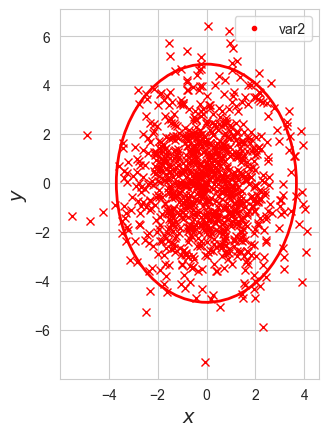

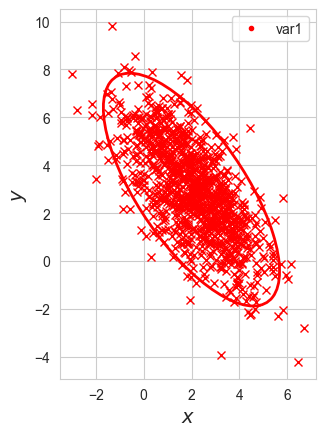

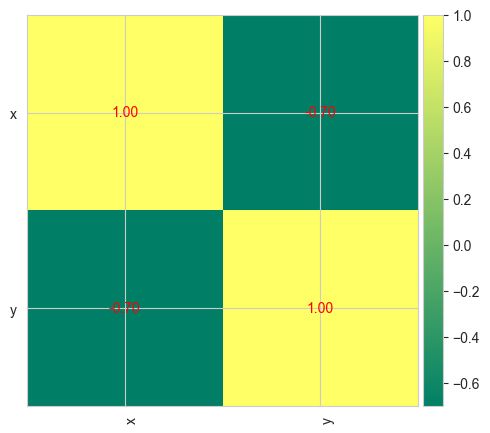

In [7]:
var1V = MCVectorVar(name=NameUnit('var1', 'Unit_var1'))

v_mean = np.zeros((2))
v_std = np.ones((2))*2
v_std[0] = 1.5

var1V.set_vector_param(v_mean, v_std)
var1V.generate_numbers()
var1V.print_stat()
var1V.pickle()

var2V = MCVectorVar(name=NameUnit('var2', 'Unit_var2'))
var2V.generate_numbers(file='var1V.pkl')
var2V.print_stat()
plot_2D(var2V, number=1000)

var3V = var1V
v_mean[0] = 2
v_mean[1] = 3
corr = np.eye(2, dtype=float)
corr[0,1] = -0.7
corr[1,0] = -0.7
var3V.set_vector_param(v_mean=v_mean, v_std=v_std, corr=corr)
var3V.generate_numbers()
var3V.print_stat()
plot_2D(var3V, number=1000)
plotCorrMatrixSmall(var3V.runData.corr_matrix, ['x', 'y'])


## Make the simlest MC Simulation

In [8]:
from empir19nrm02.MC import DistributionParam, MCVar, MCSimulation, NameUnit, MCVectorVar, pickle_copy, save_to_csv, save_to_excel, load_from_csv, load_from_excel, StatDataVector

mc1 = MCVar(name=NameUnit('V1', 'U1'), distribution=DistributionParam(mean=1.,stddev=2., distribution='normal'))
mc2 = MCVar(name=NameUnit('V2', 'U2'), distribution=DistributionParam(mean=2.,stddev=4., distribution='triangle'))
mc3 = MCVar(name=NameUnit('V3', 'U3'), distribution=DistributionParam(mean=3.,stddev=6., distribution='uniform'))

# define some output data (as MCVar to make an analysis after the run)
mcOut1 = MCVar(name=NameUnit('Plus1','UnitPlus1'))
mcOut2 = MCVar(name=NameUnit('Plus2','UnitPlus2'))
def model_easy( a, b, c):
    return [a+b, b+c]

input = [mc1, mc2, mc3]
output = [mcOut1, mcOut2]

sim = MCSimulation(trials=100000)
# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)
# generate/load the random numbers
sim.generate()
# calculate the model
sim.calculate_model(model_easy)

print( sim.trials)
res_data = sim.get_result_db()
res_data

100000


,Input,Unit,Mean,StdDev,Distr,Plus1,u(Plus1),Plus2,u(Plus2)
0,V1,U1,1.00000000,2.00000000,normal,3.00416728,2.00345016,5.00000000,0.00000000
0,V2,U2,2.00000000,4.00000000,triangle,3.00054793,3.99359004,5.00054793,3.99359004
0,V3,U3,3.00000000,6.00000000,uniform,3.00000000,0.00000000,5.01114654,5.98857035
0,All,,0.00000000,0.00000000,,3.00471522,4.46043799,5.01169447,7.19835151


Value= [1.0041672823394137, 2.003450163917474] Inteval(95%)= 7.867095498074303 U= 3.9335477490371513
Value= [2.0005479342117205, 3.9935900406724283] Inteval(95%)= 15.200039411262843 U= 7.600019705631421
Value= [3.0111465363898295, 5.988570353583305] Inteval(95%)= 19.739750388468412 U= 9.869875194234206


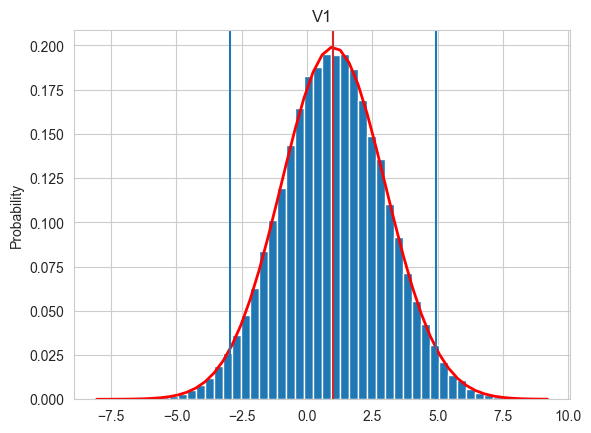

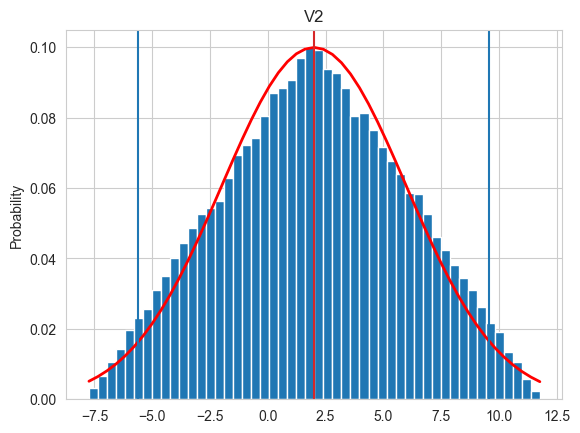

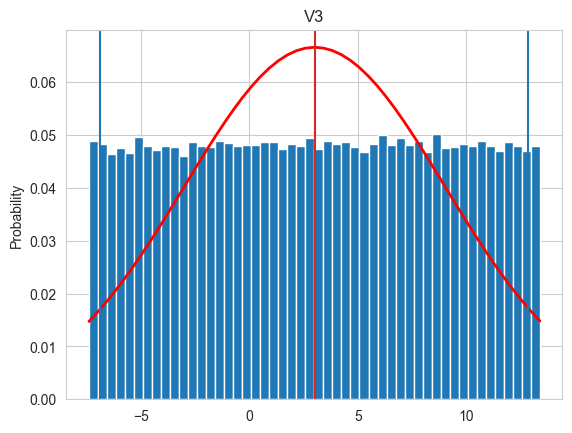

In [9]:
from empir19nrm02.tools import plotHistScales
def get_name(i:int)->str:
    return res_data['Input'].values[i]
#display some histograms
for i in range(len(input)):
    var = sim.input_var[i]
    plotHistScales( var.val, add_distribution=True, title=get_name(i), xLabel='')


Value= [3.0041672823394143, 2.003450163917474] Inteval(95%)= 7.867095498074303 U= 3.9335477490371513
Value= [5.0, 0.0] Inteval(95%)= 0.0 U= 0.0
Value= [3.00054793421172, 3.9935900406724283] Inteval(95%)= 15.200039411262843 U= 7.600019705631421
Value= [5.0005479342117205, 3.9935900406724283] Inteval(95%)= 15.200039411262843 U= 7.600019705631421
Value= [3.0, 0.0] Inteval(95%)= 0.0 U= 0.0
Value= [5.01114653638983, 5.988570353583305] Inteval(95%)= 19.739750388468412 U= 9.869875194234206
Value= [3.0047152165511344, 4.460437994519257] Inteval(95%)= 17.07236120225641 U= 8.536180601128205
Value= [5.01169447060155, 7.19835150577591] Inteval(95%)= 26.947965797523487 U= 13.473982898761744


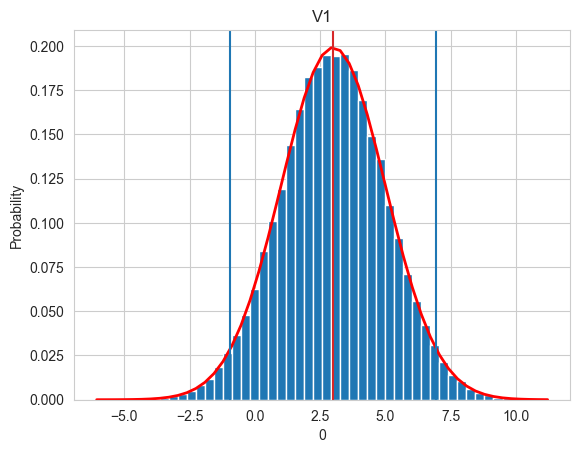

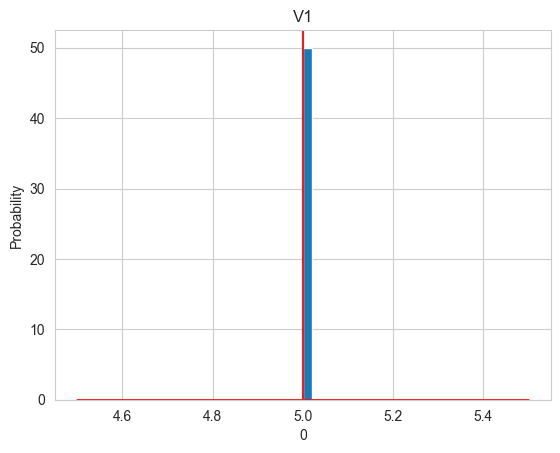

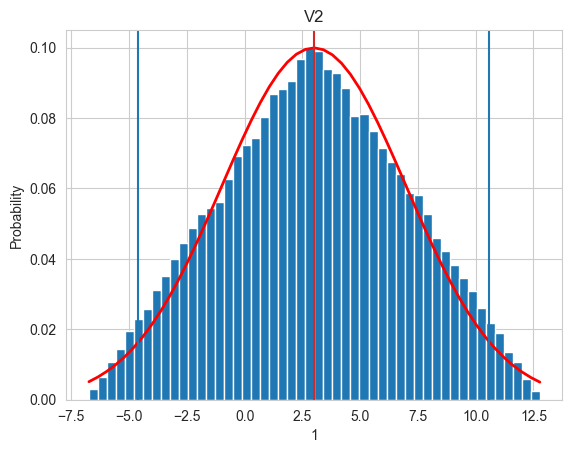

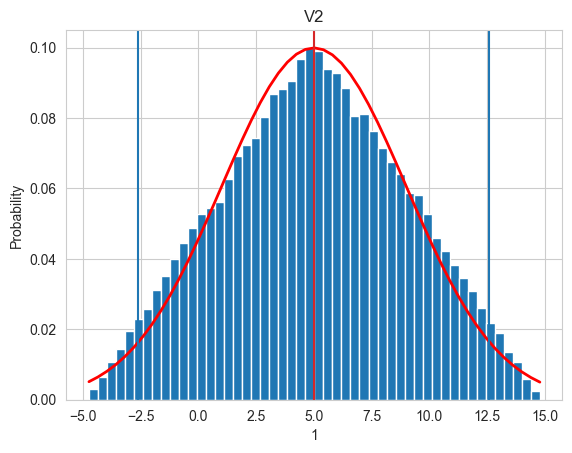

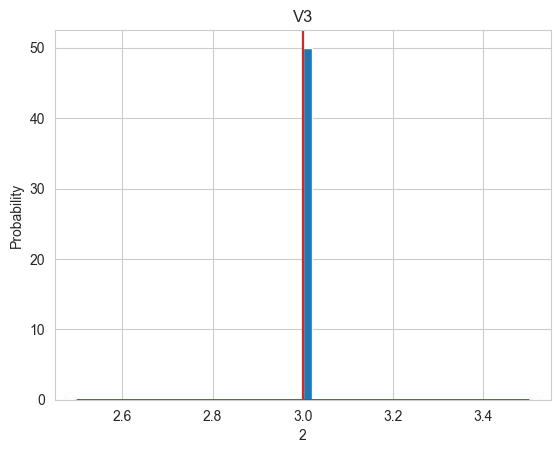

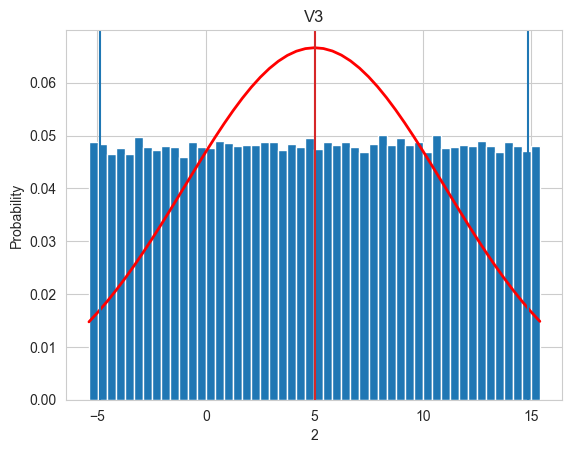

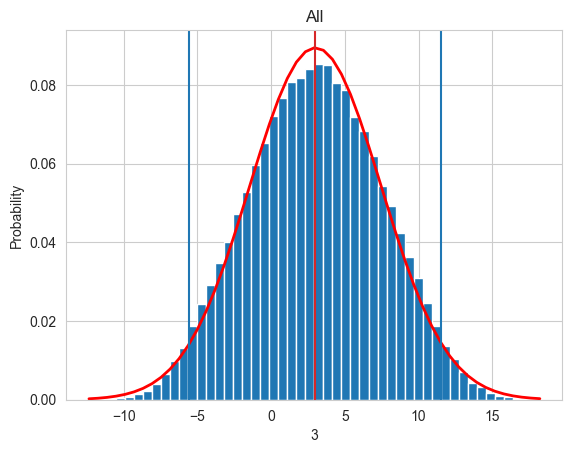

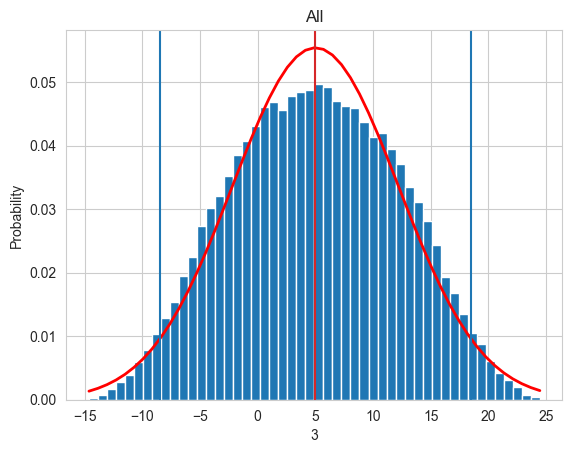

In [10]:
#display some histograms
for i in range(len(input)+1):
    var = sim.output_var[i]
    plotHistScales( var[0].val, add_distribution=True, title=get_name(i), xLabel=str(i))
    plotHistScales( var[1].val, add_distribution=True, title=get_name(i), xLabel=str(i))

# Test base function model with [Fourier](https://doi.org/10.1088/1681-7575/aa7b39) or [Chebyshev](https://doi.org/10.5194/amt-11-3595-2018) base functions

## Generate some base functions (Fig. 1, Fig. B1)

0.0
1.0
1.0000000000000002
1.0
1.0000000000000002


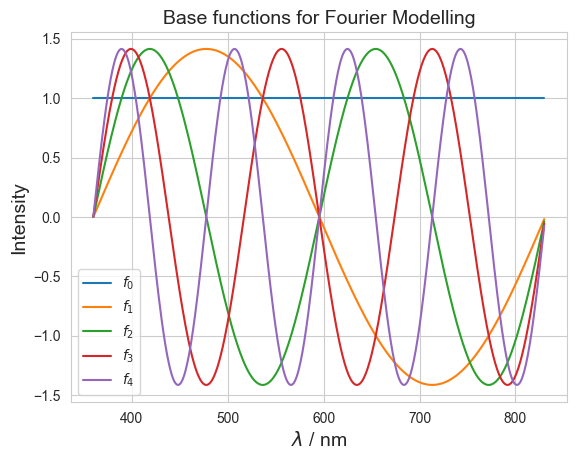

0.0
1.0
1.0
0.9999999999999999
1.0


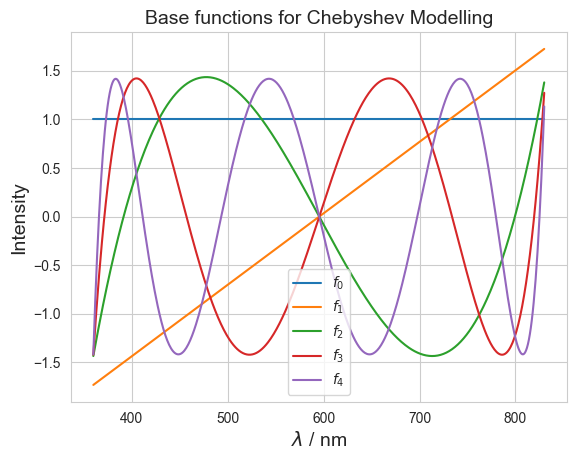

In [11]:
wl = lx.getwlr([360,830,1])
base_function_steps = len(wl)

def plot_base_functions( mode):
    for number_base in range(5):
        baseFunctions = generate_base_functions(mode + ' '  + str(number_base)+ ' o s ng', base_function_steps, 1)
        pyplot.plot( wl, baseFunctions, label=r'$f_{' + str(number_base) + '}$')
        print( np.std(baseFunctions))
    if 'f' in mode:
        pyplot.title( 'Base functions for Fourier Modelling', size=label_font_size)
    else:
        pyplot.title( 'Base functions for Chebyshev Modelling', size=label_font_size)

    pyplot.xlabel('$\lambda$ / nm', size=label_font_size)
    pyplot.ylabel('Intensity', size=label_font_size)
    pyplot.legend()

plot_base_functions('f')
save_fig(out_dir, 'base_functions_f')
plot_base_functions('c')
save_fig(out_dir, 'base_functions_c')


2.220446049250313e-16
0.15492031031767736
0.40896364711915695
0.794596722414349
0.2952926747754052


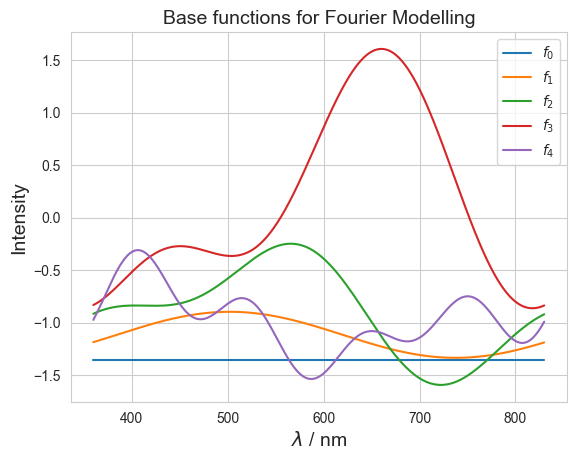

In [12]:
wl = lx.getwlr([360,830,1])
base_function_steps = len(wl)

def plot_base_functions( mode):
    for number_base in range(5):
        baseFunctions = generate_base_functions(mode + ' '  + str(number_base)+ ' o 1f', base_function_steps, 1)
        pyplot.plot( wl, baseFunctions, label=r'$f_{' + str(number_base) + '}$')
        print( np.std(baseFunctions))
    if 'f' in mode:
        pyplot.title( 'Base functions for Fourier Modelling', size=label_font_size)
    else:
        pyplot.title( 'Base functions for Chebyshev Modelling', size=label_font_size)

    pyplot.xlabel('$\lambda$ / nm', size=label_font_size)
    pyplot.ylabel('Intensity', size=label_font_size)
    pyplot.legend()

plot_base_functions('f')
save_fig(out_dir, 'base_functions_f_1f')
#plot_base_functions('c')
#save_fig(out_dir, 'base_functions_c')

## Generate the real $\delta(\lambda)*u_c$ functions (part if equation (8))

org_function:
True (o): equal to the paper
False: special handling of the full correlated term gamma_0

1.734723475976807e-18
0.0024299482340443715
0.004357947074445733
0.010589254197287346
0.011021886940220882


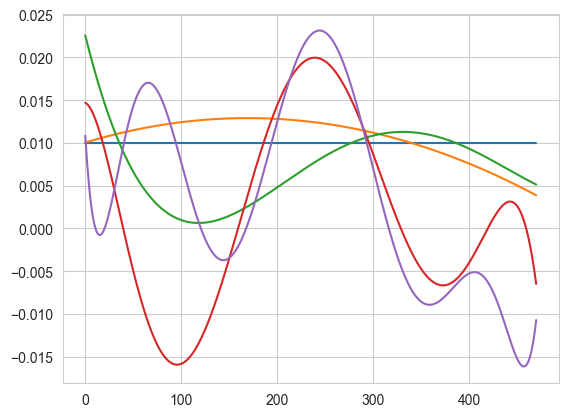

In [13]:
for number_base in range(5):
    baseFunctions = generate_base_functions('c ' + str(number_base) + ' o', base_function_steps, 0.01)
    pyplot.plot( baseFunctions)
    print( np.std(baseFunctions))


5.204170427930421e-18
0.009588211552260145
0.008167309983349707
0.007761727149280238
0.00911948124549618


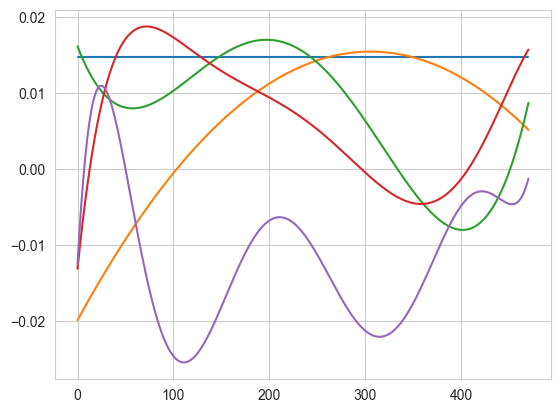

In [14]:
for number_base in range(5):
    baseFunctions = generate_base_functions('c ' + str(number_base), base_function_steps, 0.01)
    pyplot.plot( baseFunctions)
    print( np.std(baseFunctions))

## Generalte some base functions and check the standard deviation at each wavelength

The standard deviation f (single=False) should be equal to 1: 0.999058762740931
The standard deviation f 1f(single=False) should be equal to 1: 1.0079608434248506
The standard deviation c (single=False) should be equal to 1: 1.0427531709691598
The standard deviation f (single=True) should be equal to 1: 0.9995922842689224
The standard deviation c (single=True) should be equal to 1: 1.0567235902752794


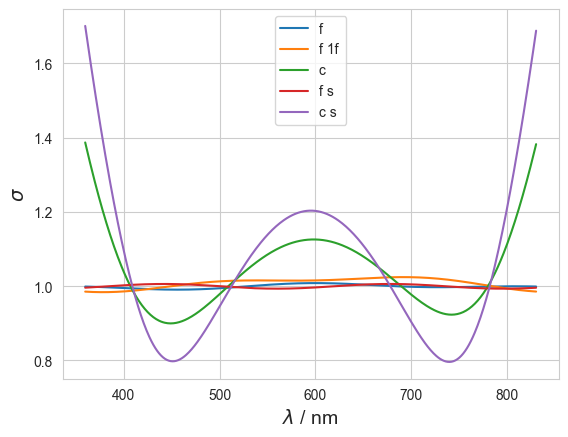

In [15]:
trials = 1000
def check_std( mode, mode2 = '', single = False):
    baseFunctions = np.zeros((trials, base_function_steps))
    number_base = 1
    single_str = ' s ' if single else ' '
    for i in range(trials):
        baseFunctions[i] = generate_base_functions(mode + ' ' + str(number_base) + single_str + ' o' + ' ' + mode2, base_function_steps, 1)

    std_dev = np.std(baseFunctions, axis=0)
    pyplot.plot( wl, std_dev , label=mode + single_str + mode2)
    print(f'The standard deviation {mode} {mode2}(single={single}) should be equal to 1: {np.mean(std_dev)}')

check_std('f')
check_std('f', '1f')
check_std('c')
check_std('f', single=True)
check_std('c', single=True)

pyplot.xlabel('$\lambda$ / nm', size=label_font_size)
pyplot.ylabel('$\sigma$', size=label_font_size)
pyplot.legend()


## Generate the Table 1 in the paper [Fourier](https://doi.org/10.1088/1681-7575/aa7b39) using both base function settings and in aditon also only one base function ('s') to check the influence of the single frequency only.

In [16]:
import pandas as pd
from empir19nrm02.tools import sumMC
elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,47, 50,60,70,80,90,100,150,200,235]

def FourierTableP( trials, wl, SPD, uSPD, mode = 'f', mode2 = '', single = ' '):
    wl_elements = wl.shape[0]
    print( wl_elements)
    #elements2Run = [10]
    petriTable = pd.DataFrame()
    rMatrixSPD = np.zeros((trials, wl.shape[0]))
    start_data =np.vstack((wl, SPD))
    XYZ = lx.spd_to_xyz( start_data, relative=False, cieobs='1931_2')
    Yxy = lx.xyz_to_Yxy (XYZ)
    print( Yxy)
    x0 = Yxy[0,1]
    y0 = Yxy[0,2]
    L0 = Yxy[0,0]
    CCT0 = lx.xyz_to_cct(XYZ)[0,0]
    print( CCT0)
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_base_functions( mode + ' ' + str(numberNew) + ' o' + single + ' ' + mode2, wl_elements, uSPD)
            rMatrixSPD[j] = (1+rMatrix)*SPD
        tmp_data =np.vstack(( wl, rMatrixSPD))
        XYZ = lx.spd_to_xyz( tmp_data, relative=False, cieobs='1931_2')
        Yxy = lx.xyz_to_Yxy (XYZ, cieobs='1931_2')
        xData = Yxy[:, 1]
        yData = Yxy[:, 2]
        #pyplot.plot(xData, yData)
        L = Yxy[:, 0]
        CCT = lx.xyz_to_cct(XYZ)
        CCT.resize(trials)
        # Luminance
        [Lvalues, Linterval] = sumMC(L / L0, Coverage=0.95)
        #CCT
        [CCTvalues, CCTinterval] = sumMC(CCT, Coverage=0.95)
        #(x,y)
        [xvalues, xinterval] = sumMC(xData, Coverage=0.95)
        [yvalues, yinterval] = sumMC(yData, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'dL_mean': Lvalues[0], 'L_std': Lvalues[1], 'L_95%': (Linterval[1]-Linterval[0])/2., \
            'dCCT_mean': (CCTvalues[0]-CCT0), 'CCT_std': CCTvalues[1], 'CCT_95%': (CCTinterval[1] - CCTinterval[0]) / 2., \
            'dx_mean': xvalues[0]-x0, 'x_std': xvalues[1], 'x_95%': (xinterval[1] - xinterval[0]) / 2., \
            'dy_mean': yvalues[0]-y0, 'y_std': yvalues[1], 'y_95%': (yinterval[1] - yinterval[0]) / 2., \
             } , dtype = 'float')

        petriTable = pd.concat( [petriTable, df])
        print( numberNew, end=' ')
    return petriTable

In [20]:
print( 'FourierTableP')
trials = 2000

wl_scale = np.arange(360,830+1,1)
lxSpdInterpolate = lx.cie_interp(lx._CIE_ILLUMINANTS['A'], wl_new = wl_scale, kind = 'S')

uSPD=np.ones_like(lxSpdInterpolate[1])*0.01
#pyplot.plot( spd_init[0], uSPD)
petriTablePF=FourierTableP(trials, lxSpdInterpolate[0], lxSpdInterpolate[1], uSPD, mode = 'f', single=' ')
petriTablePF.to_excel(out_dir + '/' +  'FourierP_f.xlsx')
petriTablePF

petriTablePF1f=FourierTableP(trials, lxSpdInterpolate[0], lxSpdInterpolate[1], uSPD, mode = 'f', mode2='1f', single=' ')
petriTablePF1f.to_excel(out_dir + '/' +  'FourierP_f_1f.xlsx')
petriTablePF1f

petriTablePFs=FourierTableP(trials, lxSpdInterpolate[0], lxSpdInterpolate[1], uSPD, mode = 'f', single='s')
petriTablePFs.to_excel(out_dir + '/' +  'FourierP_fs.xlsx')
petriTablePFs

petriTablePC=FourierTableP(trials, lxSpdInterpolate[0], lxSpdInterpolate[1], uSPD, mode = 'c', single=' ')
petriTablePC.to_excel(out_dir + '/' +  'FourierP_c.xlsx')
petriTablePC

petriTablePCs=FourierTableP(trials, lxSpdInterpolate[0], lxSpdInterpolate[1], uSPD, mode = 'c', single='s')
petriTablePCs.to_excel(out_dir + '/' +  'FourierP_cs.xlsx')
petriTablePCs

FourierTableP
471
[[7.3693e+06 4.4757e-01 4.0744e-01]]
2855.542688043744
0 1 2 3 4 5 6 7 8 9 10 20 30 40 47 50 60 70 80 90 100 150 200 235 471
[[7.3693e+06 4.4757e-01 4.0744e-01]]
2855.542688043744
0 1 2 3 4 5 6 7 8 9 10 20 30 40 47 50 60 70 80 90 100 150 200 235 471
[[7.3693e+06 4.4757e-01 4.0744e-01]]
2855.542688043744
0 1 2 3 4 5 6 7 8 9 10 20 30 40 47 50 60 70 80 90 100 150 200 235 471
[[7.3693e+06 4.4757e-01 4.0744e-01]]
2855.542688043744
0 1 2 3 4 5 6 7 8 9 10 20 30 40 47 50 60 70 80 90 100 150 200 235 471
[[7.3693e+06 4.4757e-01 4.0744e-01]]
2855.542688043744
0 1 2 3 4 5 6 7 8 9 10 20 30 40 47 50 60 70 80 90 100 150 200 235 

,N,dL_mean,L_std,L_95%,dCCT_mean,CCT_std,CCT_95%,dx_mean,x_std,x_95%,dy_mean,y_std,y_95%
0,0.00000000,1.01000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000
0,1.00000000,1.00011726,0.01097437,0.01549019,0.10445105,10.18275307,14.39210206,-0.00000475,0.00081195,0.00115014,-0.00000087,0.00041799,0.00059274
0,2.00000000,1.00004989,0.00777549,0.01088560,1.01889056,21.69317303,30.64848558,-0.00005829,0.00156320,0.00219243,-0.00000334,0.00076344,0.00106507
0,3.00000000,1.00007763,0.00576925,0.00812261,-0.36205030,26.39330219,37.27478624,0.00003024,0.00144843,0.00204968,-0.00000280,0.00104324,0.00146562
0,4.00000000,1.00000384,0.00404037,0.00560946,0.15889828,24.04167989,34.36881822,-0.00000500,0.00089939,0.00128718,0.00000561,0.00143240,0.00203940
0,5.00000000,1.00000979,0.00249026,0.00353294,-0.49018450,20.01684974,28.13491393,0.00001779,0.00067742,0.00095203,-0.00002934,0.00119651,0.00168319
0,6.00000000,1.00005173,0.00139248,0.00195462,-0.27213189,15.37623124,21.46363210,0.00001141,0.00071785,0.00100205,-0.00001614,0.00054448,0.00076257
0,7.00000000,0.99999818,0.00061406,0.00086526,-0.26263460,10.26154738,14.46911735,0.00001592,0.00058076,0.00081882,-0.00000490,0.00016202,0.00022840
0,8.00000000,0.99999827,0.00015794,0.00022322,-0.05186344,5.65116677,7.98551237,0.00000251,0.00028947,0.00040831,-0.00000232,0.00016206,0.00022927
0,9.00000000,0.99999736,0.00011562,0.00016244,0.07952277,2.51122936,3.55376767,-0.00000242,0.00008094,0.00011469,0.00000523,0.00016307,0.00023048


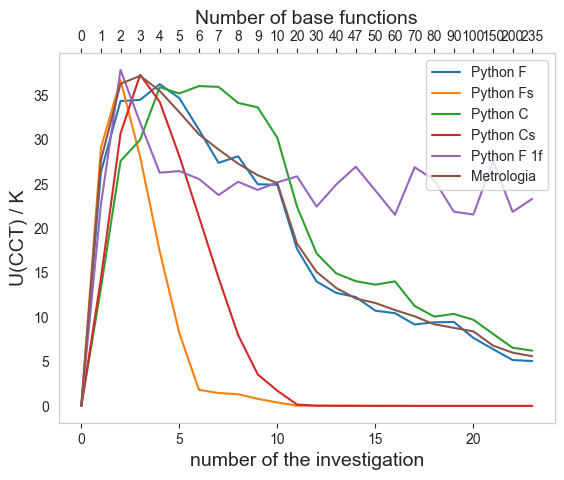

In [19]:
lines =petriTablePF.shape[0]
eval=np.zeros((lines, 6))
eval[:,0]=petriTablePF["N"].to_numpy().T
eval[:,1]=petriTablePF["CCT_95%"].to_numpy().T
eval[:,2]=petriTablePFs["CCT_95%"].to_numpy().T
eval[:,3]=petriTablePC["CCT_95%"].to_numpy().T
eval[:,4]=petriTablePCs["CCT_95%"].to_numpy().T
eval[:,5]=petriTablePF1f["CCT_95%"].to_numpy().T
xNumber = range(lines)
petriDataList = [0, 27.7, 36.3, 37.2, 35.5, 33.1, 30.6, 28.9, 27.3, 26.0, 25.1, 18.3, 15.1, 13.3, 12.1, 11.6, 10.8, 10.1, 9.2, 8.8, 8.4, 6.8,6.0,5.6]
fig = pyplot.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_xlabel(r"number of the investigation",fontsize=label_font_size)
ax1.set_ylabel('U(CCT) / K',fontsize=label_font_size)
ax1.plot(xNumber, eval[:,1], label='Python F')
ax1.plot(xNumber, eval[:,2], label='Python Fs')
ax1.plot(xNumber, eval[:,3], label='Python C')
ax1.plot(xNumber, eval[:,4], label='Python Cs')
ax1.plot(xNumber, eval[:,5], label='Python F 1f')
ax1.plot(xNumber, petriDataList, label='Metrologia')

new_tick_locations = range( lines)
def tick_function(X):
    return ["%d" % elements2Run[z] for z in X]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Number of base functions",fontsize=label_font_size)
ax1.legend()
ax1.grid(False)
ax2.grid(False)
save_fig(out_dir, 'MetCompCCT_Table1')

In [ ]:
lines =petriTablePF.shape[0]
eval=np.zeros((lines, 5))
eval[:,0]=petriTablePF["N"].to_numpy().T
eval[:,1]=petriTablePF["L_95%"].to_numpy().T
eval[:,2]=petriTablePFs["L_95%"].to_numpy().T
eval[:,3]=petriTablePC["L_95%"].to_numpy().T
eval[:,4]=petriTablePCs["L_95%"].to_numpy().T
xNumber = range(lines)
#petriDataList = [0, 27.7, 36.3, 37.2, 35.5, 33.1, 30.6, 28.9, 27.3, 26.0, 25.1, 18.3, 15.1, 13.3, 12.1, 11.6, 10.8, 10.1, 9.2, 8.8, 8.4, 6.8,6.0,5.6]
fig = pyplot.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_xlabel(r"number of the investigation",fontsize=label_font_size)
ax1.set_ylabel('U($L_{\mathrm{rel}}$) / A.U.',fontsize=label_font_size)
ax1.plot(xNumber, eval[:,1], label='Python F')
ax1.plot(xNumber, eval[:,2], label='Python Fs')
ax1.plot(xNumber, eval[:,3], label='Python C')
ax1.plot(xNumber, eval[:,4], label='Python Cs')
#ax1.plot(xNumber, petriDataList, label='Metrologia')

new_tick_locations = range( lines)
def tick_function(X):
    return ["%d" % elements2Run[z] for z in X]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Number of base functions",fontsize=label_font_size)
ax1.legend()
ax1.grid(False)
ax2.grid(False)
save_fig(out_dir, 'MetCompL_Table1')